#  Salary Prediction 

This notebook serves as the entry point for our salary prediction pipeline.

It reads the input dataset, performs cleaning and transformation, trains a model, and evaluates its performance.
The core idea is to build a simple but modular pipeline which is flexible enough to incorporate aditional features and models.

---

##  Table of Contents

1. [Imports](#imports)  
2. [EDA – Raw Data Check](#eda-raw)  
3. [EDA – Visual Exploration](#eda-visual)  
4. [Preprocessing](#preprocessing)  
5. [Feature Transformation](#features)  
6. [Model Training & Evaluation](#model)


###  1. Imports

All core libraries (Pandas, NumPy, Seaborn...) and our own modular code from `src/`.


In [ ]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


from src.preprocessing import prepare_data
from src import eda
from src.features import transform_features
from src.model import split_data, train_model, evaluate_model



###  2. EDA – Raw Data Check

Before running the pipeline, we quickly check for:
- Consistency between the two CSV files (people & salary)
- Null values
- General data structure

This is optional but helps ensure the data looks clean enough to proceed.


In [2]:
pd.set_option('display.max_rows', None)  
pd.set_option('display.max_columns', None)  
pd.set_option('display.width', None)  
pd.set_option('display.expand_frame_repr', False)  

#Load raw data (people and salary info)
df_people = pd.read_csv("data/people.csv")
df_salary = pd.read_csv("data/salary.csv")

#Check consistency in both df
eda.check_id_consistency(df_people, df_salary)

#Check how many nulls are present in people.csv
eda.check_nulls(df_people, name="people.csv")


df_merged = df_people.merge(df_salary, on="id", how="left")

# Check how many rows of salary has nulls.
eda.count_salary_nulls(df_merged)

# Count and display rows that have at least one null value
eda.count_rows_with_any_null(df_merged, name="merged df")

#Print shape, types and head of the merged dataset
eda.print_df_overview(df_merged, name="merged df")



🔎 IDs in people.csv which are not in salary.csv: 0
🔎 IDs in salary.csv which are not in people.csv: 0

📋 amount of nulls per column people.csv:
id                     0
Age                    5
Gender                 5
Education Level        5
Job Title              5
Years of Experience    2
dtype: int64

 rows in salary that are null: 2

 amount of rows that have at least a NaN value: 14
      id   Age  Gender Education Level                         Job Title  Years of Experience    Salary
51    51  33.0    Male        Master's                               NaN                  7.0   85000.0
60    60  51.0  Female        Master's                               NaN                 23.0  170000.0
139  139  43.0  Female             NaN  Senior Product Marketing Manager                 14.0  120000.0
172  172   NaN     NaN             NaN                               NaN                  NaN       NaN
219  219  40.0     NaN      Bachelor's       Senior Sales Representative               

###  3. EDA – Visual Exploration

Here we look at the distribution of variables like Age, Salary, and Years of Experience.

Also checks how many job titles appear more than a threshold.  
It helps us decide which ones to group under "Other".


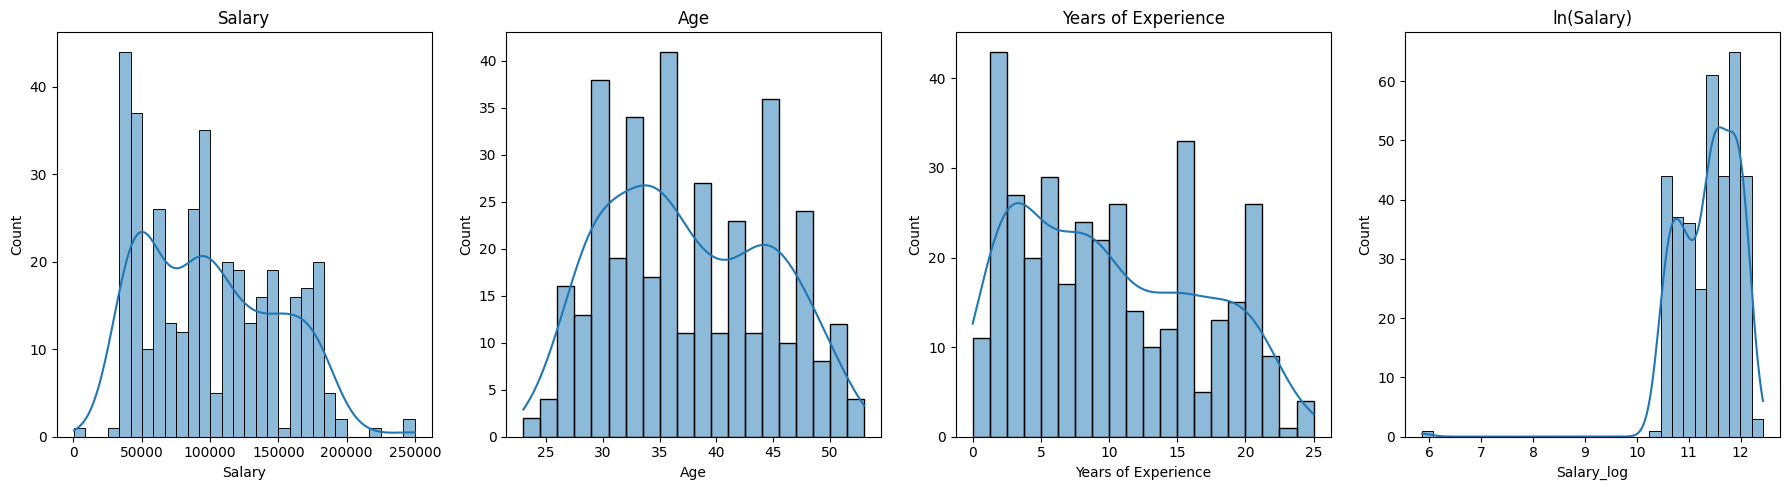


 Amount of rows with job titles that appear more than 6 times: 84
 Job Titles with more than 6 repetitions:
Job Title
Director of Marketing                    12
Director of Operations                   10
Senior Business Analyst                  10
Senior Marketing Manager                  8
Senior Marketing Analyst                  8
Junior Business Analyst                   8
Senior Project Manager                    7
Senior Data Scientist                     7
Junior Business Development Associate     7
Senior Financial Analyst                  7
Name: count, dtype: int64


In [3]:
#Reload data for visualization purposes
df_people = pd.read_csv("data/people.csv")
df_salary = pd.read_csv("data/salary.csv")

df_merged_exp = df_people.merge(df_salary, on="id", how="left")


# Drop null rows and apply log transform to salary (based on earlier EDA)
df_clean_exp = df_merged_exp.dropna().copy()
df_clean_exp["Salary_log"] = np.log(df_clean_exp["Salary"])

#Plotting different data distributions.
eda.plot_distributions(df_clean_exp)
eda.count_job_titles(df_clean_exp, threshold=6)



### 4. Preprocessing

Loads and merges both datasets, removes null rows, and adds a log-transformed Salary column.

Everything here is done through `prepare_data()` inside `src/preprocessing.py`.


In [4]:
# Load and clean data (null removal + log transform on Salary)

df_clean = prepare_data("data/people.csv", "data/salary.csv")
#df_clean.head()


###  5. Feature Transformation

We apply:
- One-hot encoding to `Education Level`
- Job Title grouping (threshold-based)

Handled by `transform_features()` inside `src/features.py`.


In [5]:

job_title_threshold = 3  #Minimum count to keep job title (else grouped as "other")
X, y = transform_features(df_clean, job_threshold=job_title_threshold)



###  6. Model Training & Evaluation

We train a Linear Regression model and evaluate its performance using:
- MAE & RMSE
- 95% confidence intervals (via bootstrap)
- Comparison with a DummyRegressor

All metrics are printed.

In [6]:

#Split data into training and testing sets
X_train, X_test, y_train, y_test = split_data(X, y, test_size=0.2, random_state=42)

#Train linear regression model
model = train_model(X_train, y_train)

# Evaluate performance with MAE, RMSE and 95% CI ( with bootstrap)
evaluate_model(model, X_test, y_test)



 performance on test:
----------------------------------
 MAE: $12,479.65
Average prediction $12,480
95% confidence interval: $9,649.94 – $16,182.89

 RMSE : $18,731.27
95% confidence interval: $12,614.08 – $24,449.51

 baseline model (DummyRegressor – mean prediction):
-----------------------------------------------------
 MAE (dummy): $40,703.57
 RMSE (dummy): $50,706.82
